In [55]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [73]:
import asyncio
import os

from dotenv import load_dotenv
from langchain_core.messages import HumanMessage
from langchain_mcp_adapters.tools import load_mcp_tools
from langchain_openai import AzureChatOpenAI
from langgraph.prebuilt import create_react_agent
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.client import MultiServerMCPClient
load_dotenv()

llm = AzureChatOpenAI(
    deployment_name=os.getenv("OPENAI_API_DEPLOYMENT"),
    azure_endpoint=os.getenv("OPENAI_API_ENDPOINT"),
    temperature=0,
)

# fetch tool

In [75]:
fetch_params = {"command": "uvx", "args": ["mcp-server-fetch"]}

fetch_tools_param = StdioServerParameters(
    command="uvx",
    args=["mcp-server-fetch"],
)
fetch_tools_param


StdioServerParameters(command='uvx', args=['mcp-server-fetch'], env=None, cwd=None, encoding='utf-8', encoding_error_handler='strict')

In [94]:
async with stdio_client(fetch_tools_param) as (read, write):
    async with ClientSession(read, write) as session:
        try:
            
            await session.initialize()
    
            # Get tools
            tools = await load_mcp_tools(session)
            print(tools)
            agent = create_react_agent(llm, tools)
            response = await agent.ainvoke({"messages": "can you get data from this url https://github.com/modelcontextprotocol/servers/tree/main/src/fetch"})
            print(response)
            
        except Exception as e:
            print(e)

## puppeteer

In [95]:
puppeteer_params = StdioServerParameters(
    command="npx",
    args=["-y","@modelcontextprotocol/server-puppeteer" ],
)

async with stdio_client(puppeteer_params) as (read, write):
    async with ClientSession(read, write) as session:
        try:
            await session.initialize()
    
            # Get tools
            tools = await load_mcp_tools(session)
            print(tools)
            agent = create_react_agent(llm, tools)
            response = await agent.ainvoke({"messages": "can you get data from this url https://github.com/modelcontextprotocol/servers/tree/main/src/fetch and summarize it" })
            print(response['messages'][-1].content)
        
        except Exception as e:
            print(e)

## file manager

In [99]:

sandbox_path = os.path.abspath(os.path.join(os.getcwd(), "sandbox"))
files_params = {"command": "npx", "args": ["-y", "@modelcontextprotocol/server-filesystem", sandbox_path]}

file_tools = StdioServerParameters(
    command="npx",
    args=["-y","@modelcontextprotocol/server-filesystem", sandbox_path ],
)


async with stdio_client(file_tools) as (read, write):
    async with ClientSession(read, write) as session:
        try:
            await session.initialize()
    
            # Get tools
            tools = await load_mcp_tools(session)
            print(tools)
            agent = create_react_agent(llm, tools)
            response = await agent.ainvoke({"messages": "write a detail difference between Langchain vs langraph in table format and save it in md file" })
            print(response['messages'][-1].content)
        
        except Exception as e:
            print(e)


# playwright

In [97]:

playwright_params = {"command": "npx", "args": ["@playwright/mcp@latest"]}

playwright_params = StdioServerParameters(
    command = "npx",
    args = ["@playwright/mcp@latest"]
)
playwright_params


StdioServerParameters(command='npx', args=['@playwright/mcp@latest'], env=None, cwd=None, encoding='utf-8', encoding_error_handler='strict')

In [98]:
async with stdio_client(playwright_params) as (read, write):
    async with ClientSession(read, write) as session:
        
        await session.initialize()

        # Get tools
        tools = await load_mcp_tools(session)
        print(tools)
        agent = create_react_agent(llm, tools)
        weather_response = await agent.ainvoke({"messages": "how is the weather today in bengaluru, use web search tool"})
        print(weather_response['messages'][-1].content)

## MultiServerMCPClient

### And now.. bring on the Agent with Tools!

In [100]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent


In [101]:
instructions = """
You browse the internet to accomplish your instructions.
You are highly capable at browsing the internet independently to accomplish your task, 
including accepting all cookies and clicking 'not now' as
appropriate to get to the content you need. If one website isn't fruitful, try another. 
Be persistent until you have solved your assignment,
trying different options and sites as needed.
"""

sandbox_path = os.path.abspath(os.path.join(os.getcwd(), "sandbox"))

client = MultiServerMCPClient(
    {
        "web_search_tool": {
            "command": "npx", 
            "args": ["@playwright/mcp@latest"],
            "transport": "stdio",
        },
        "browser_automation": {
                'command': 'npx', 
                'args': ['-y', '@modelcontextprotocol/server-puppeteer'],
                "transport": "stdio",
            
        },
        "fetch": {
            "command": "uvx",
            "args": ["mcp-server-fetch"],
            "transport": "stdio",
        },
        "filemanager":{
            "command": "npx",
            "args": ["-y", "@modelcontextprotocol/server-filesystem", sandbox_path],
            "transport": "stdio",
        }
    }
)


In [102]:
tools = await client.get_tools()
agent = create_react_agent(llm, tools)

# weather tool

In [65]:
weather_response = await agent.ainvoke({"messages": "try to search and get the weather today in bengaluru"})
weather_response['messages'][-1].content

'The weather today in Bengaluru (Sampangi Rama Nagar, Karnataka) is as follows:\n\n- **Current Temperature:** 23°C with light drizzle.\n- **High/Low:** 25°C / 21°C\n- **Wind:** 31 km/h\n- **Humidity:** 87%\n- **Dew Point:** 21°C\n- **Pressure:** 1010.2 mb\n- **UV Index:** 8 of 11\n- **Visibility:** 6.44 km\n- **Moon Phase:** Waning Crescent\n\n### Forecast:\n- **Morning:** 22°C, Light Rain/Windy\n- **Afternoon:** 24°C, Few Showers, Chance of Rain 33%\n- **Evening:** 22°C, Showers, Chance of Rain 52%\n- **Overnight:** 21°C, Few Showers, Chance of Rain 32%\n\n### Hourly Forecast:\n- **Now:** 23°C, Rain, Chance of Rain 83%\n- **12:30:** 24°C, Rain, Chance of Rain 83%\n- **13:30:** 24°C, Rain, Chance of Rain 93%\n- **14:30:** 24°C, Rain, Chance of Rain 90%\n- **15:30:** 25°C, Rain, Chance of Rain 78%\n\nThe air quality index is good, indicating minimal impact.'

# file manager

In [66]:
filemanager_response = await agent.ainvoke({"messages": "try to fetch latest forcast of weather in south india and save it into a well formated md file"})
filemanager_response['messages'][-1].content

'The latest weather forecast for South India has been successfully saved in a markdown file. You can find it at the following location:\n\n`C:\\Users\\SIVERMA\\Documents\\Experimenting\\DeepSeek\\agents\\sandbox\\south_india_weather_forecast.md`'

## fetch

In [87]:
fetch_response = await agent.ainvoke({"messages": "can you get data from this url https://cobusgreyling.medium.com/using-langchain-with-model-context-protocol-mcp-e89b87ee3c4c"})
fetch_response['messages'][-1].content

'The article "Using LangChain With Model Context Protocol (MCP)" by Cobus Greyling on Medium discusses the Model Context Protocol (MCP), an open-source protocol developed by Anthropic. MCP aims to address the isolation of Large Language Model (LLM) applications from external data sources and tools. It standardizes how LLM-based applications connect to diverse systems, enabling seamless, secure, and scalable data exchange between AI agents and external resources.\n\nMCP uses a client-server architecture, allowing developers to build reusable, modular connectors with pre-built servers for popular platforms. Its open-source nature encourages innovation while maintaining security through features like granular permissions. MCP aims to transform AI agents into context-aware, interoperable systems integrated into digital environments.\n\nThe article also provides step-by-step instructions for connecting MCP servers to LangGraph agents and using MCP tools, including setting up a virtual envir

## combined

In [106]:
fetch_response = await agent.ainvoke({"messages": "summarize the content from this https://cobusgreyling.medium.com/using-langchain-with-model-context-protocol-mcp-e89b87ee3c4c and put this in a well documented md file how to use MCP servers"})
fetch_response['messages'][-1].content

'I have created a well-documented markdown file on how to use MCP servers with LangChain. You can find the file at the following path:\n\n[C:\\Users\\SIVERMA\\Documents\\Experimenting\\DeepSeek\\how_to_use_mcp_servers.md](sandbox/C:\\Users\\SIVERMA\\Documents\\Experimenting\\DeepSeek\\how_to_use_mcp_servers.md)\n\nThe document includes an introduction to the Model Context Protocol (MCP), its key features, and a step-by-step guide on setting up MCP with LangChain. If you have any questions or need further assistance, feel free to ask!'

# with langgraph

In [134]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition


tools = await client.get_tools()
tools[:3]


[StructuredTool(name='browser_close', description='Close the page', args_schema={'type': 'object', 'properties': {}, 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, metadata={'title': 'Close browser', 'readOnlyHint': True, 'destructiveHint': False, 'idempotentHint': None, 'openWorldHint': True}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000018D6A29CE00>),
 StructuredTool(name='browser_resize', description='Resize the browser window', args_schema={'type': 'object', 'properties': {'width': {'type': 'number', 'description': 'Width of the browser window'}, 'height': {'type': 'number', 'description': 'Height of the browser window'}}, 'required': ['width', 'height'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, metadata={'title': 'Resize browser window', 'readOnlyHint': True, 'destructiveHint': False, 'idempotentHint': None, 'openWorldHi

## Add Push Notification

In [150]:
from langchain.agents import Tool
import requests


pushover_token = "a1axxxxxxxxxxxxxxxxxxxxxxxxxx"
pushover_user = "ga8kxxxxxxxxxxxxxxxxxxxxxxxxx"
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str, sound_type: str = "magic"):
    """Send a push notification to the user"""
    res = requests.post(
        pushover_url, 
        data = {"token": pushover_token, "user": pushover_user, "message": text, "sound": sound_type})
    print(res)

tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

In [151]:
tools = tools + [tool_push]

In [152]:

def call_model(state: MessagesState):
    response = llm.bind_tools(tools).invoke(state["messages"])
    return {"messages": response}

builder = StateGraph(MessagesState)
builder.add_node(call_model)
builder.add_node(ToolNode(tools))
builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model",
    tools_condition,
)
builder.add_edge("tools", "call_model")
graph = builder.compile()

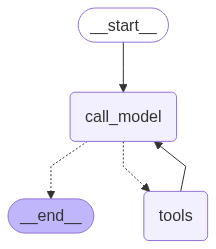

In [153]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [143]:
weather_response = await graph.ainvoke({"messages": "latest news as of today and how they will manipulate the sotck market in upcomin days use web search tool? put the response in well formated md file and save it"})

In [144]:
weather_response['messages'][-1].content

'The latest news and their potential impact on the stock market have been compiled and saved in a markdown file. You can find the file at:\n\n`C:\\Users\\SIVERMA\\Documents\\Experimenting\\DeepSeek\\agents\\sandbox\\latest_news_stock_market.md`'

# with push notify

In [160]:
push_response = await graph.ainvoke({"messages": "get the weather forcast with online search for tomorrow in bengaluru and notify user for accordingly be ready"})

In [161]:
push_response['messages'][-1].content

"I've sent you a push notification with the weather alert for Bengaluru tomorrow. Stay prepared for thundery showers and a fresh breeze!"